# Model Relationships

Define foreign key relationships between tables. This guide shows how different foreign key placements create different relationship types, with actual schema diagrams.

In [1]:
import datajoint as dj

schema = dj.Schema('howto_relationships')
schema.drop(prompt=False)
schema = dj.Schema('howto_relationships')

[2026-01-17 00:48:25,941][INFO]: DataJoint 2.0.0a22 connected to root@127.0.0.1:3306


## Basic Foreign Key

Reference another table with `->`:

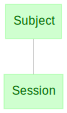

In [2]:
@schema
class Subject(dj.Manual):
    definition = """
    subject_id : varchar(16)
    ---
    species : varchar(32)
    """

@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session_idx : int32
    ---
    session_date : date
    """

dj.Diagram(Subject) + dj.Diagram(Session)

The `->` syntax:

- Inherits all primary key attributes from the referenced table
- Creates a foreign key constraint
- Establishes dependency for cascading deletes
- Defines workflow order (parent must exist before child)

## Foreign Key Placement

Where you place a foreign key determines the relationship type:

| Placement | Relationship | Diagram Line |
|-----------|--------------|-------------|
| Entire primary key | One-to-one extension | Thick solid |
| Part of primary key | One-to-many containment | Thin solid |
| Secondary attribute | One-to-many reference | Dashed |

## One-to-Many: Containment

Foreign key as **part of** the primary key (above `---`):

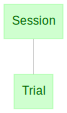

In [3]:
@schema
class Trial(dj.Manual):
    definition = """
    -> Session              # Part of primary key
    trial_idx : int32      # Additional PK attribute
    ---
    outcome : varchar(20)
    """

dj.Diagram(Session) + dj.Diagram(Trial)

**Thin solid line** = containment. Trials are identified **within** their session. Trial #1 for Session A is different from Trial #1 for Session B.

Notice `Trial` is **underlined** — it introduces a new [dimension](../explanation/entity-integrity.md#schema-dimensions) (`trial_idx`). A dimension is an independent axis of variation in your data, introduced by a table that defines new primary key attributes.

## One-to-Many: Reference

Foreign key as **secondary attribute** (below `---`):

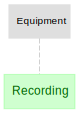

In [4]:
@schema
class Equipment(dj.Lookup):
    definition = """
    equipment_id : varchar(16)
    ---
    equipment_name : varchar(60)
    """
    contents = [
        {'equipment_id': 'rig1', 'equipment_name': 'Main Recording Rig'},
        {'equipment_id': 'rig2', 'equipment_name': 'Backup Rig'},
    ]

@schema
class Recording(dj.Manual):
    definition = """
    recording_id : uuid         # Independent identity
    ---
    -> Equipment                # Reference, not part of identity
    duration : float32
    """

dj.Diagram(Equipment) + dj.Diagram(Recording)

**Dashed line** = reference. Recordings have their own global identity independent of equipment.

Both tables are **underlined** — each introduces its own dimension.

## One-to-One: Extension

Foreign key **is** the entire primary key:

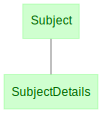

In [5]:
@schema
class SubjectDetails(dj.Manual):
    definition = """
    -> Subject              # Entire primary key
    ---
    weight : float32
    notes : varchar(1000)
    """

dj.Diagram(Subject) + dj.Diagram(SubjectDetails)

**Thick solid line** = extension. Each subject has at most one details record. The tables share identity.

Notice `SubjectDetails` is **not underlined** — it doesn't introduce a new dimension.

## Optional (Nullable) Foreign Keys

Make a reference optional with `[nullable]`:

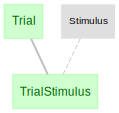

In [6]:
@schema
class Stimulus(dj.Lookup):
    definition = """
    stimulus_type : varchar(32)
    """
    contents = [{'stimulus_type': 'visual'}, {'stimulus_type': 'auditory'}]

@schema
class TrialStimulus(dj.Manual):
    definition = """
    -> Trial
    ---
    -> [nullable] Stimulus   # Some trials have no stimulus
    """

dj.Diagram(Trial) + dj.Diagram(Stimulus) + dj.Diagram(TrialStimulus)

Only secondary foreign keys (below `---`) can be nullable.

**Note:** The `[nullable]` modifier is NOT visible in diagrams — check the table definition.

## Unique Foreign Keys

Enforce one-to-one on a secondary FK with `[unique]`:

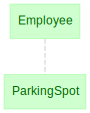

In [7]:
@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int64
    ---
    name : varchar(60)
    """

@schema
class ParkingSpot(dj.Manual):
    definition = """
    spot_id : int64
    ---
    -> [unique] Employee     # Each employee has at most one spot
    location : varchar(30)
    """

dj.Diagram(Employee) + dj.Diagram(ParkingSpot)

**Note:** The `[unique]` modifier is NOT visible in diagrams — the line is still dashed. Check the table definition to see the constraint.

### Nullable Unique Foreign Keys

Combine `[nullable, unique]` for optional one-to-one relationships:

```python
-> [nullable, unique] ParentTable
```

Multiple rows can have NULL values because SQL's UNIQUE constraint does not consider NULLs as equal to each other. This is useful when:

- Not every child needs to reference a parent
- But each parent can be referenced by at most one child

## Many-to-Many

Use an association table with composite primary key:

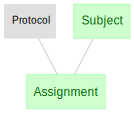

In [8]:
@schema
class Protocol(dj.Lookup):
    definition = """
    protocol_id : varchar(16)
    ---
    protocol_name : varchar(100)
    """
    contents = [
        {'protocol_id': 'iacuc_01', 'protocol_name': 'Mouse Protocol'},
        {'protocol_id': 'iacuc_02', 'protocol_name': 'Rat Protocol'},
    ]

@schema
class Assignment(dj.Manual):
    definition = """
    -> Subject
    -> Protocol
    ---
    assigned_date : date
    """

dj.Diagram(Subject) + dj.Diagram(Protocol) + dj.Diagram(Assignment)

Two **thin solid lines** converge into `Assignment`. Each subject-protocol combination appears at most once.

Notice `Assignment` is **not underlined** — it doesn't introduce a new dimension, just combines existing ones.

## Hierarchies

Cascading one-to-many relationships create tree structures:

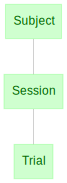

In [9]:
# Already defined: Subject -> Session -> Trial
# Show the full hierarchy
dj.Diagram(Subject) + dj.Diagram(Session) + dj.Diagram(Trial)

Primary keys cascade: Trial's key is `(subject_id, session_idx, trial_idx)`.

All three tables are **underlined** — each introduces a dimension.

## Part Tables

Part tables use the `-> master` alias to reference their enclosing table:

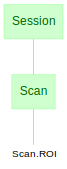

In [10]:
@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan_idx : int32
    ---
    depth : float32
    """

    class ROI(dj.Part):
        definition = """
        -> master               # References Scan's primary key
        roi_idx : int32        # Additional dimension
        ---
        x : float32
        y : float32
        """

dj.Diagram(Session) + dj.Diagram(Scan) + dj.Diagram(Scan.ROI)

`-> master` is the standard way to declare the foreign key to the enclosing table. It references the master's primary key.

Notice:
- `Scan` is **underlined** (introduces `scan_idx`)
- `Scan.ROI` is **underlined** (introduces `roi_idx`) — Part tables CAN introduce dimensions

## Renamed Foreign Keys

Reference the same table multiple times with `.proj()` to rename attributes:

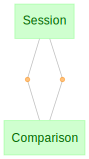

In [11]:
@schema
class Comparison(dj.Manual):
    definition = """
    -> Session.proj(session_a='session_idx')
    -> Session.proj(session_b='session_idx')
    ---
    similarity : float32
    """

dj.Diagram(Session) + dj.Diagram(Comparison)

**Orange dots** indicate renamed foreign keys. Hover over them to see the projection expression.

This creates attributes `session_a` and `session_b`, both referencing `Session.session_idx`.

## Computed Dependencies

Computed tables inherit keys from their dependencies:

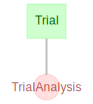

In [12]:
@schema
class TrialAnalysis(dj.Computed):
    definition = """
    -> Trial
    ---
    score : float64
    """
    
    def make(self, key):
        self.insert1({**key, 'score': 0.95})

dj.Diagram(Trial) + dj.Diagram(TrialAnalysis)

**Thick solid line** to a **red (Computed) table** that is **not underlined**.

Computed tables never introduce dimensions — their primary key is entirely inherited from dependencies.

## Full Schema View

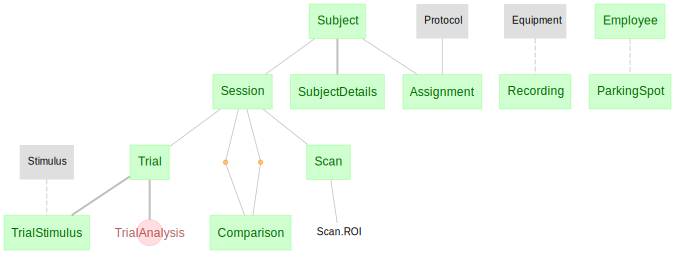

In [13]:
dj.Diagram(schema)

## Schema as DAG

DataJoint schemas form a directed acyclic graph (DAG). Foreign keys:

- Define data relationships
- Prescribe workflow execution order
- Enable cascading deletes

There are no cyclic dependencies—parent tables must always be populated before their children.

## Summary

| Pattern | Declaration | Line Style | Dimensions |
|---------|-------------|------------|------------|
| One-to-one | FK is entire PK | Thick solid | No new dimension |
| One-to-many (contain) | FK + other attrs in PK | Thin solid | Usually new dimension |
| One-to-many (ref) | FK in secondary | Dashed | Independent dimensions |
| Many-to-many | Two FKs in PK | Two thin solid | No new dimension |
| Part table | `-> master` | Thin solid | May introduce dimension |

## See Also

- [Define Tables](define-tables.md) — Table definition syntax
- [Design Primary Keys](design-primary-keys.md) — Key selection strategies
- [Read Diagrams](read-diagrams.ipynb) — Diagram notation reference
- [Delete Data](delete-data.md) — Cascade behavior

In [14]:
schema.drop(prompt=False)